In [1]:
import sys
import itertools as it
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import numpy.random as rnd
import altair as alt
import pandas as pd
from scipy.special import logit, expit, logsumexp

In [2]:
Y = 365

In [3]:
arr = 10 * np.exp(-50*(np.linspace(0.0, 1.0, Y) - 0.5)**2)

def random_redds(arr=arr):
    redds = rnd.poisson(arr)
    return redds

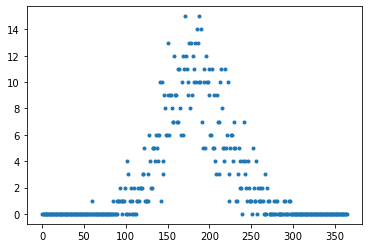

In [4]:
plt.plot(random_redds(), ".")

In [5]:
def random_temp(mu=11.0, sigma=0.7):
    temp = rnd.normal(mu, sigma, size=Y)
    return temp

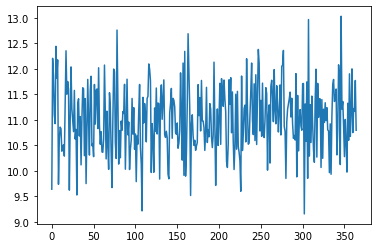

In [6]:
plt.plot(random_temp())

In [7]:
def random_survival(alpha=30, beta=120, size=1):
    surv = rnd.beta(alpha, beta, size=25)
    return logit(surv)

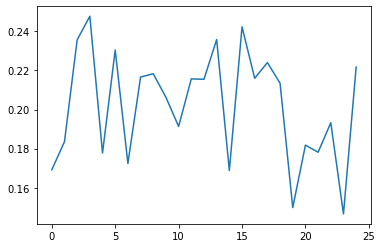

In [8]:
plt.plot(expit(random_survival()))

In [9]:
def compute_hazard(temp, redds, t_crit, beta_t, alpha=0.00056, beta=0.001044):
    aut = beta * temp.cumsum() + alpha
    hatch = ((i, aut[i + 1:], aut[i]) for i in range(len(aut) - 1))
    hatch = [1 + i + np.searchsorted(xs, 1 + x) for (i, xs, x) in hatch]
    hatch = np.array(hatch, dtype=int)
    mask = (hatch < Y - 1)
    hzd = beta * np.clip(temp[:-1], t_crit, None).cumsum()
    hzd = hzd[hatch[mask]] - hzd[mask]
    rds = redds[:-1]
    rds = rds[mask].astype(np.float64) 
    rds = np.log(rds) - np.log(rds.sum())
    hzd = logsumexp(rds - hzd)
    return hzd

In [10]:
def objective(x, temp, redds, surv):
    t_crit = x[0]
    beta_t = x[1]
    base_srv = x[2]
    hzd = [compute_hazard(temp[i, :], redds[i, :], t_crit, beta_t) for i in range(len(surv))]
    hzd = np.array(hzd, dtype=np.float64)
    err = logit(np.exp(hzd) * expit(base_srv)) - surv
    return (err * err).sum()

In [44]:
N = 25
temp = np.array([random_temp() for i in range(N)])
redds = np.array([random_redds() for i in range(N)])
surv = random_survival(size=N)

def resample_and_fit(x0, num=10):
    sigma = np.repeat(surv.std(ddof=1), len(surv))
    res = []
    for i in range(num):
        surv_res = rnd.normal(surv, sigma)
        def obj(x):
            ret = objective(x, temp, redds, surv_res)
            return ret
        r = opt.minimize(obj, x0, method='Nelder-Mead')
        if r.success:
            res.append(r)
        else:
            print(f"divergent optimization: {r}", file=sys.stderr)
    return res

In [47]:
def scatter_plot_with_marginals(df, xcol, ycol, nbins=25):
    base = alt.Chart(df)
    
    xdom = (df[xcol].min(), df[xcol].max())
    ydom = (df[ycol].min(), df[ycol].max())

    xscale = alt.Scale(domain=xdom, nice=nbins)
    yscale = alt.Scale(domain=ydom, nice=nbins)

    area_args = {'opacity': .5, 'interpolate': 'step'}


    points = base.mark_circle().encode(
        alt.X(f'{xcol}:Q', scale=xscale),
        alt.Y(f'{ycol}:Q', scale=yscale),
    )
    
    top_hist = base.mark_area(**area_args).encode(
        alt.X(f'{xcol}:Q',
            # when using bins, the axis scale is set through
            # the bin extent, so we do not specify the scale here
            # (which would be ignored anyway)
            bin=alt.Bin(maxbins=nbins, extent=xscale.domain),
            stack=None,
            title='',
         ),
        alt.Y('count()', stack=None, title='')
    ).properties(height=60)

    right_hist = base.mark_area(**area_args).encode(
        alt.Y(f'{ycol}:Q',
              bin=alt.Bin(maxbins=nbins, extent=yscale.domain),
              stack=None,
              title='',
         ),
        alt.X('count()', stack=None, title=''),
    ).properties(width=60)
    
    res = top_hist & (points | right_hist)
    return res

In [49]:
res = resample_and_fit([11, 0.01, logit(0.3)], num=500)
res = (r.x for r in res)
res = [(x[0], x[1], expit(x[2])) for x in res]
res = np.array(res, dtype=np.float64)

<ipython-input-9-32d41f969d6e>:11: RuntimeWarning: divide by zero encountered in log
  rds = np.log(rds) - np.log(rds.sum())
divergent optimization:  final_simplex: (array([[17.89172309,  1.24407719, 29.90009522],
       [17.89172309,  1.24401927, 29.89870494],
       [17.89172309,  1.24408268, 29.90022713],
       [17.89172309,  1.24409075, 29.90042075]]), array([1.2173311, 1.2173311, 1.2173311, 1.2173311]))
           fun: 1.2173310989537058
       message: 'Maximum number of function evaluations has been exceeded.'
          nfev: 602
           nit: 340
        status: 1
       success: False
             x: array([17.89172309,  1.24407719, 29.90009522])


In [50]:
df = pd.DataFrame(columns=["Tc", "beta", "background"], data=res)

In [51]:
scatter_plot_with_marginals(df, xcol="Tc", ycol="beta", nbins=50)

alt.VConcatChart(...)

In [56]:
res1 = resample_and_fit([11, 10.0, logit(0.3)], num=500)
res1 = (r.x for r in res1)
res1 = [(x[0], x[1], expit(x[2])) for x in res1]
res1 = np.array(res1, dtype=np.float64)

<ipython-input-9-32d41f969d6e>:11: RuntimeWarning: divide by zero encountered in log
  rds = np.log(rds) - np.log(rds.sum())


In [57]:
df1 = pd.DataFrame(columns=["Tc", "beta", "background"], data=res1)

In [58]:
scatter_plot_with_marginals(df1, xcol="Tc", ycol="beta", nbins=50)

alt.VConcatChart(...)